In [3]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import precision_score,f1_score,recall_score,classification_report,accuracy_score
import joblib
from imblearn.over_sampling import SMOTE
from tqdm import tqdm


In [207]:
#file paths
input_path ="GUIDE_train.csv"
data=pd.read_csv(input_path)

In [5]:
data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [23]:
data.isnull().sum()* 100

Id                            0
OrgId                         0
IncidentId                    0
AlertId                       0
Timestamp                     0
DetectorId                    0
AlertTitle                    0
Category                      0
MitreTechniques       546838600
IncidentGrade           5134000
ActionGrouped         946077300
ActionGranular        946077300
EntityType                    0
EvidenceRole                  0
DeviceId                      0
Sha256                        0
IpAddress                     0
Url                           0
AccountSid                    0
AccountUpn                    0
AccountObjectId               0
AccountName                   0
DeviceName                    0
NetworkMessageId              0
EmailClusterId        942002500
RegistryKey                   0
RegistryValueName             0
RegistryValueData             0
ApplicationId                 0
ApplicationName               0
OAuthApplicationId            0
ThreatFa

In [9]:
data.shape

(9516837, 45)

In [209]:
#removing 50% and above missing data

threshold = len(data)*0.4
data = data.dropna(thresh=threshold,axis=1)

In [29]:
data.shape

(9516837, 36)

In [13]:
data.duplicated().sum()

546298

In [211]:
data.drop_duplicates()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,User,Impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,Url,Related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,Url,Related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,User,Impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,1056561956622,0,90,496631,2024-06-08T15:26:08.000Z,7,6,InitialAccess,NaN,TruePositive,CloudLogonRequest,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
9516833,1228360650033,59,196410,748366,2024-06-06T09:40:08.000Z,2,2,CommandAndControl,NaN,BenignPositive,Url,Related,98799,138268,360606,164,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
9516834,867583395122,44,14117,7425,2024-06-11T22:51:03.000Z,78,57,Exfiltration,NaN,BenignPositive,MailMessage,Impacted,98799,138268,360606,160396,441377,270,425863,453297,153085,22919,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
9516835,395136991850,43,644,8973,2024-05-20T23:01:01.000Z,52,10,Impact,NaN,BenignPositive,Ip,Related,98799,138268,465,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


In [153]:
data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
FileName                    0
FolderPath                  0
ResourceIdName              0
OSFamily                    0
OSVersion                   0
CountryCod

In [213]:
#mode imputation because of catagorial columns
data["IncidentGrade"].fillna(data["IncidentGrade"].mode()[0],inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_9272\3017238057.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["IncidentGrade"].fillna(data["IncidentGrade"].mode()[0],inplace=True)


In [215]:
data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade               0
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
FileName                    0
FolderPath                  0
ResourceIdName              0
OSFamily                    0
OSVersion                   0
CountryCod

In [23]:
data["Timestamp"]

0          2024-06-04T06:05:15.000Z
1          2024-06-14T03:01:25.000Z
2          2024-06-13T04:52:55.000Z
3          2024-06-10T16:39:36.000Z
4          2024-06-15T01:08:07.000Z
                     ...           
9516832    2024-06-08T15:26:08.000Z
9516833    2024-06-06T09:40:08.000Z
9516834    2024-06-11T22:51:03.000Z
9516835    2024-05-20T23:01:01.000Z
9516836    2024-06-03T23:51:52.000Z
Name: Timestamp, Length: 9516837, dtype: object

In [217]:
data["Timestamp"] = data["Timestamp"].str.replace(r"\.\d{3}Z$","Z",regex=True)

In [27]:
data["Timestamp"]

0          2024-06-04T06:05:15Z
1          2024-06-14T03:01:25Z
2          2024-06-13T04:52:55Z
3          2024-06-10T16:39:36Z
4          2024-06-15T01:08:07Z
                   ...         
9516832    2024-06-08T15:26:08Z
9516833    2024-06-06T09:40:08Z
9516834    2024-06-11T22:51:03Z
9516835    2024-05-20T23:01:01Z
9516836    2024-06-03T23:51:52Z
Name: Timestamp, Length: 9516837, dtype: object

In [219]:
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

In [49]:
data["Timestamp"] 

0         2024-06-04 06:05:15+00:00
1         2024-06-14 03:01:25+00:00
2         2024-06-13 04:52:55+00:00
3         2024-06-10 16:39:36+00:00
4         2024-06-15 01:08:07+00:00
                     ...           
9516832   2024-06-08 15:26:08+00:00
9516833   2024-06-06 09:40:08+00:00
9516834   2024-06-11 22:51:03+00:00
9516835   2024-05-20 23:01:01+00:00
9516836   2024-06-03 23:51:52+00:00
Name: Timestamp, Length: 9516837, dtype: datetime64[ns, UTC]

In [221]:
data["Day"] = data["Timestamp"].dt.day
data["Month"] = data["Timestamp"].dt.month
data["Year"] = data["Timestamp"].dt.year
data["Hour"] = data["Timestamp"].dt.hour
data["Time"] =data["Timestamp"].dt.time

In [223]:
data.drop("Timestamp",axis=1,inplace=True)

In [225]:
pd.set_option("display.max_columns", None)
data.head(1)

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Year,Hour,Time
0,180388628218,0,612,123247,7,6,InitialAccess,NaN,TruePositive,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,31,6,3,4,6,2024,6,06:05:15


In [42]:
data["FolderPath"].value_counts()

FolderPath
117668    8641204
0          113784
1           70685
2           60963
3           39980
           ...   
91008           1
79260           1
46080           1
94902           1
114529          1
Name: count, Length: 87832, dtype: int64

In [44]:
data["OSFamily"].value_counts()

OSFamily
5    9322565
0     190036
1       2732
2       1496
3          7
4          1
Name: count, dtype: int64

In [59]:
data["OSVersion"].value_counts()

OSVersion
66    9322572
0      187405
2        1892
1        1652
3        1125
4         732
6         362
5         266
8         132
9         109
10         89
7          81
11         66
12         54
16         38
13         32
14         31
15         22
19         18
17         17
20         16
22         15
21         14
24         13
26          7
25          7
27          6
31          5
28          5
35          4
33          4
40          3
38          3
37          3
41          3
42          3
29          3
23          2
45          2
30          2
34          2
44          2
46          2
43          2
65          1
59          1
63          1
53          1
62          1
36          1
58          1
48          1
64          1
51          1
56          1
52          1
47          1
60          1
Name: count, dtype: int64

In [57]:
data["AlertTitle"].value_counts()

AlertTitle
0         1332232
1          774539
2          597497
4          413879
3          412087
           ...   
111797          1
106429          1
110942          1
110257          1
110883          1
Name: count, Length: 86149, dtype: int64

In [53]:
data["OSVersion"].value_counts()

OSVersion
66    9322572
0      187405
2        1892
1        1652
3        1125
4         732
6         362
5         266
8         132
9         109
10         89
7          81
11         66
12         54
16         38
13         32
14         31
15         22
19         18
17         17
20         16
22         15
21         14
24         13
26          7
25          7
27          6
31          5
28          5
35          4
33          4
40          3
38          3
37          3
41          3
42          3
29          3
23          2
45          2
30          2
34          2
44          2
46          2
43          2
65          1
59          1
63          1
53          1
62          1
36          1
58          1
48          1
64          1
51          1
56          1
52          1
47          1
60          1
Name: count, dtype: int64

In [46]:
data["ResourceIdName"].value_counts()

ResourceIdName
3586    9508671
0           390
1           329
2           274
3           253
         ...   
2242          1
3072          1
3136          1
2156          1
3316          1
Name: count, Length: 2309, dtype: int64

In [48]:
data["EntityType"].value_counts()

EntityType
Ip                       2181194
User                     1932416
MailMessage              1173154
Machine                   699208
File                      688402
Url                       682578
CloudLogonRequest         638565
Mailbox                   483158
Process                   345732
MailCluster               224684
CloudApplication          216811
CloudLogonSession         212382
RegistryValue              11209
AzureResource               8166
RegistryKey                 7277
GenericEntity               4294
OAuthApplication            2595
Malware                     2580
SecurityGroup               1518
BlobContainer                306
Blob                         263
MailboxConfiguration         226
Nic                           49
IoTDevice                     31
ActiveDirectoryDomain         11
GoogleCloudResource           10
AmazonResource                 6
Container                      2
KubernetesCluster              2
ContainerImage                 2

In [50]:
data["MitreTechniques"].value_counts()

MitreTechniques
T1078;T1078.004                                        1354904
T1566.002                                               814308
T1566                                                   659591
T1133                                                   145579
T1566.001                                               136892
                                                        ...   
T1084                                                        1
T1055;T1055.003;T1055.012;T1059;T1059.001;T1106              1
T1003.001;T1055;T1055.003;T1055.012;T1106;T1550.002          1
T1055;T1055.002;T1055.003;T1055.012;T1078;T1106              1
T1078;T1078.001                                              1
Name: count, Length: 1193, dtype: int64

In [227]:
# Analyze the relationship between missing MitreTechniques and IncidentGrade
missing_data = data.groupby(data["MitreTechniques"].isnull())['IncidentGrade'].value_counts()
print(missing_data)


MitreTechniques  IncidentGrade 
False            TruePositive      1657954
                 BenignPositive    1395865
                 FalsePositive      994632
True             BenignPositive    2766292
                 TruePositive      1664759
                 FalsePositive     1037335
Name: count, dtype: int64


In [229]:
# Group by IncidentGrade and MitreTechniques and count occurrences
technique_counts=data.groupby(["IncidentGrade", "MitreTechniques"]).size().reset_index(name="count")

In [177]:
technique_counts

,IncidentGrade,MitreTechniques,count
0,BenignPositive,T0807,380
1,BenignPositive,T0807;T1204,8
2,BenignPositive,T0814,3
3,BenignPositive,T0820;T0816,595
4,BenignPositive,T0820;T0853;T0807;T0866,12
...,...,...,...
1990,TruePositive,T1598;T1566,2
1991,TruePositive,T1603,1
1992,TruePositive,T1616;T1090,4
1993,TruePositive,T1621;T1078,9


In [231]:
# Sort the counts to find the most frequent techniques for each grade
sorted_techniques= technique_counts.sort_values(["IncidentGrade","count"],ascending=[True, False])

In [233]:
sorted_techniques

,IncidentGrade,MitreTechniques,count
963,BenignPositive,T1566.002,392622
960,BenignPositive,T1566,349864
961,BenignPositive,T1566.001,90702
934,BenignPositive,T1559;T1106;T1059.005,37869
605,BenignPositive,T1078;T1078.004,36622
...,...,...,...
1576,TruePositive,T0865;T1566;T1098;T1078,1
1791,TruePositive,T1070;T1562,1
1837,TruePositive,T1098;T1556,1
1989,TruePositive,T1595;T1464,1


In [235]:
# Get the most common MitreTechnique for each IncidentGrade
most_common=sorted_techniques.loc[sorted_techniques.groupby("IncidentGrade")["count"].idxmax()]

In [237]:
most_common

,IncidentGrade,MitreTechniques,count
963,BenignPositive,T1566.002,392622
1318,FalsePositive,T1078;T1078.004,308347
1810,TruePositive,T1078;T1078.004,1009935


In [239]:
# Example fill mapping based on your results
fill_mapping = {
    "BenignPositive":"T1566.002",
    "FalsePositive":"T1078;T1078.004",
    "TruePositive":"T1078;T1078.004"
}

In [241]:
# Fill missing MitreTechniques based on IncidentGrade
for grade,technique in fill_mapping.items():
    data.loc[data["IncidentGrade"] == grade,"MitreTechniques"] = data["MitreTechniques"].fillna(technique)

In [243]:
data["MitreTechniques"].isnull().sum()

0

In [245]:
data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
DetectorId            0
AlertTitle            0
Category              0
MitreTechniques       0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Day                   0
Month                 0
Year                  0
Hour                  0
Time                  0
dtype: int64

# DATA VISUALIZATION BEFORE ENCODING

In [247]:
# Barplot for PrimaryMitreTechniques and IncidentGrade

# Create a new column with only the first technique
data["PrimaryMitreTechniques"] = data["MitreTechniques"].map(lambda x: x.split(";")[0])

In [249]:
grouped_data=data.groupby(["PrimaryMitreTechniques","IncidentGrade"]).size().reset_index(name="count")

In [225]:
#unique_grouped_data = grouped_data.drop_duplicates(subset=["PrimaryMitreTechniques"])

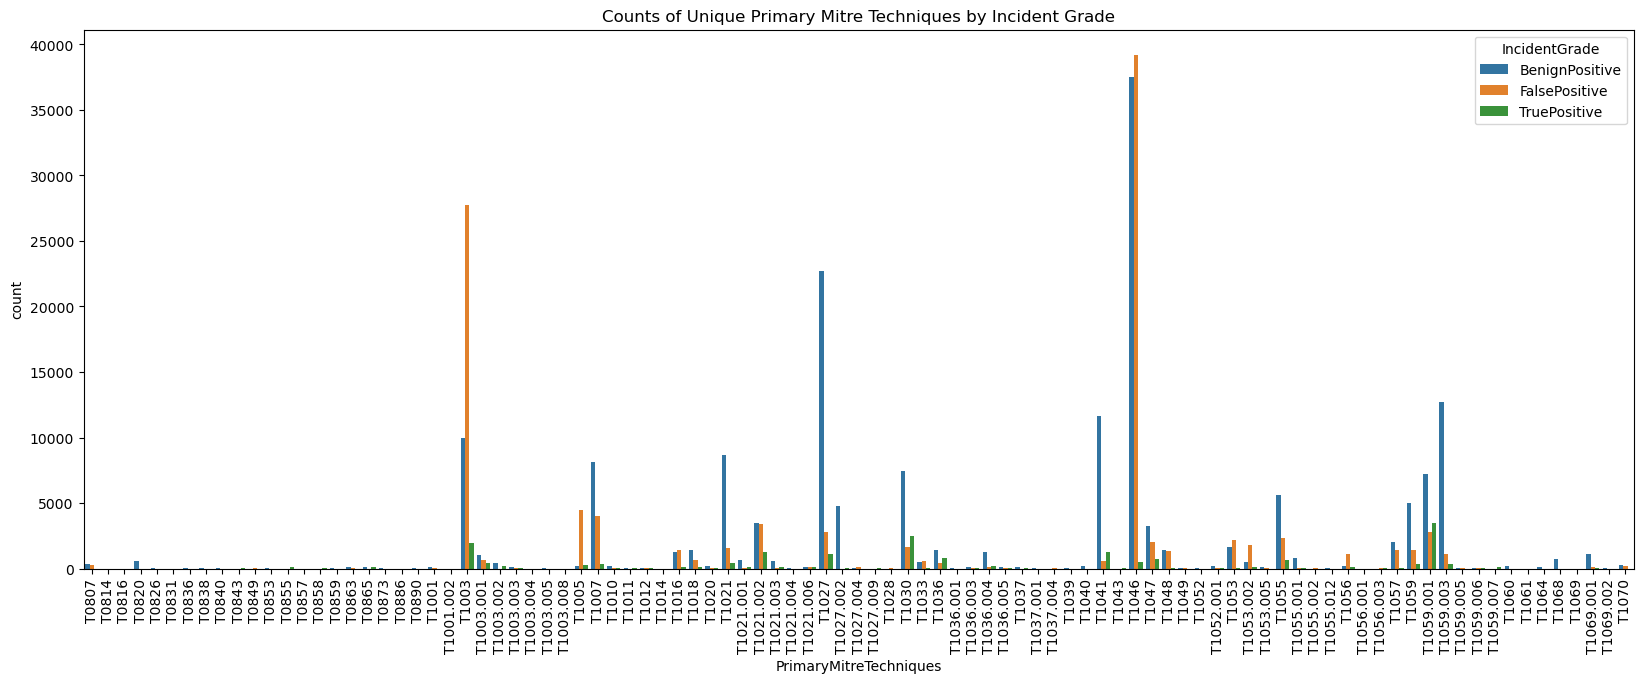

In [39]:
plt.figure(figsize=(20,7))
sns.barplot(data=grouped_data.head(200),x="PrimaryMitreTechniques",y="count",hue="IncidentGrade")
plt.xticks(rotation=90)
plt.title("Counts of Unique Primary Mitre Techniques by Incident Grade")
plt.show()

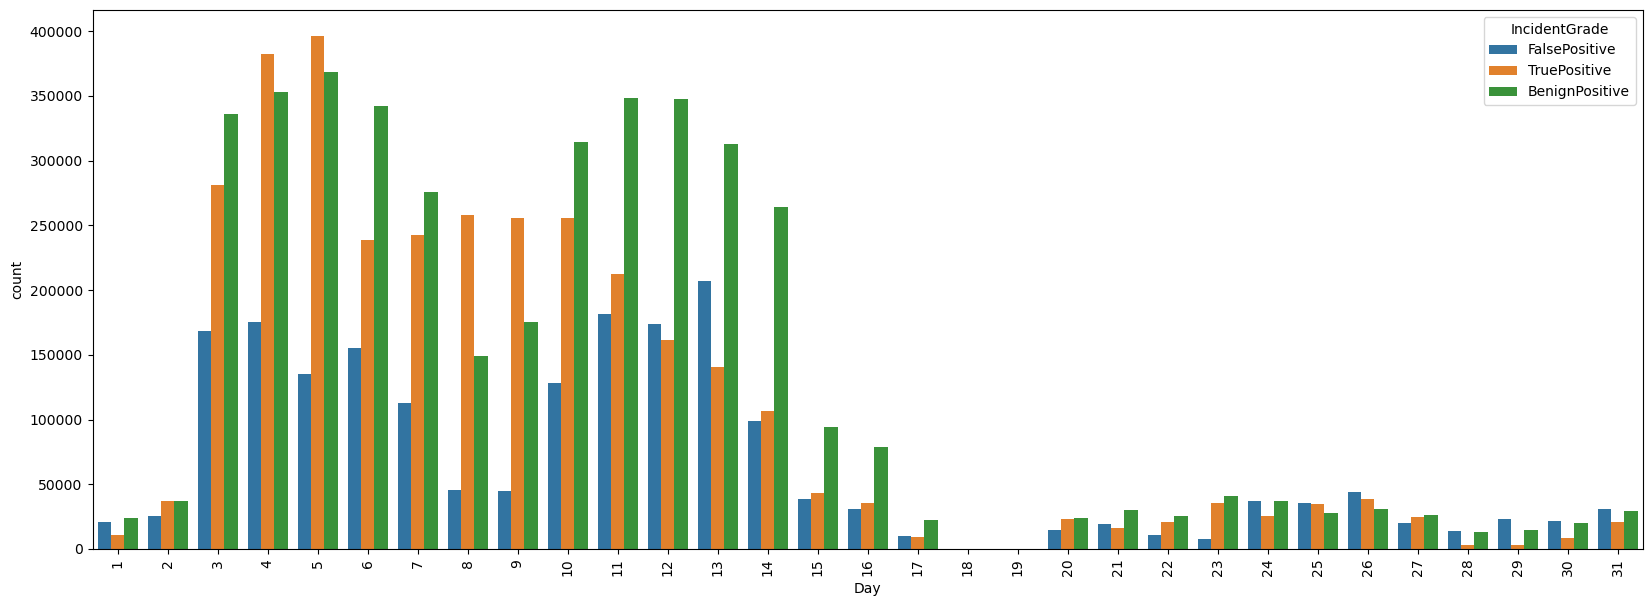

In [123]:
# Barplot for days vs incident grade

plt.figure(figsize=(20,7))
sns.countplot(data=data,x="Day",hue="IncidentGrade")
plt.xticks(rotation=90)
plt.show()

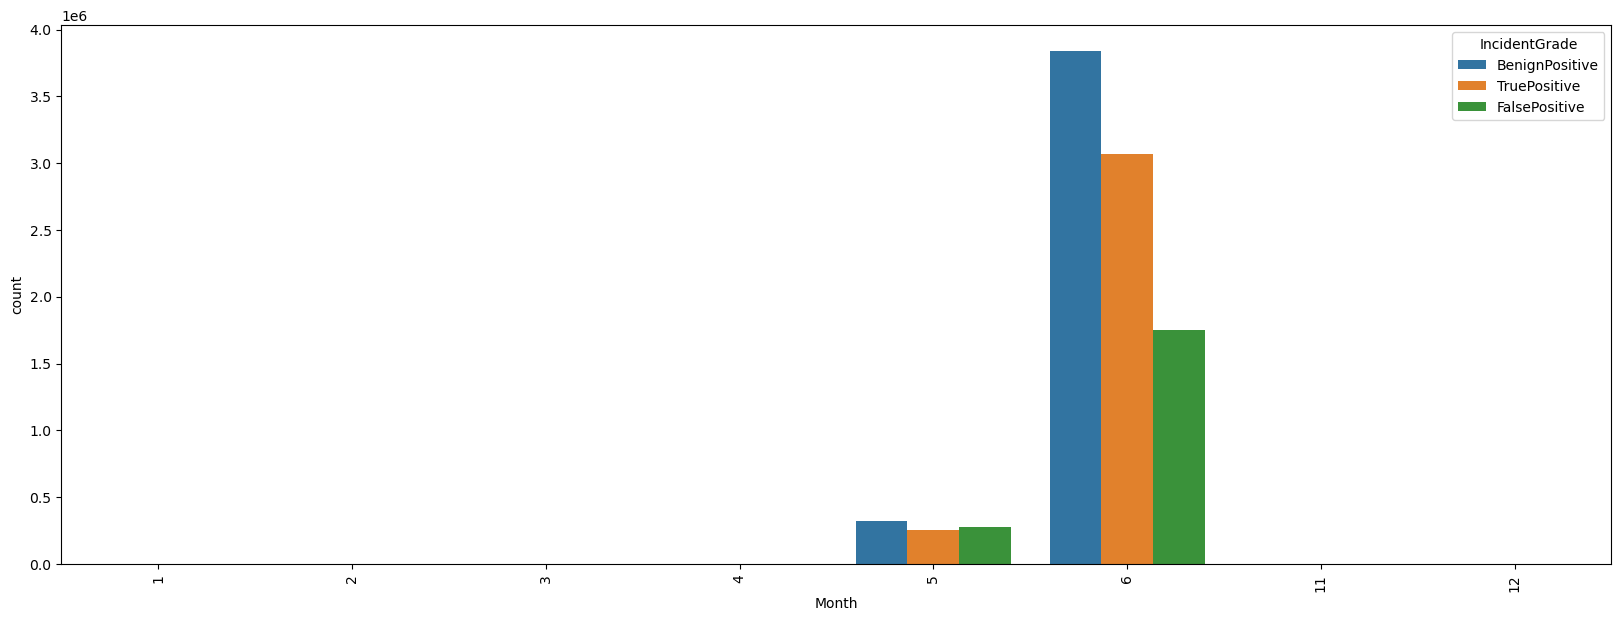

In [127]:
# Barplot for weeks vs incident grade

plt.figure(figsize=(20,7))
sns.countplot(data=data,x="Month",hue="IncidentGrade")
plt.xticks(rotation=90)
plt.show()

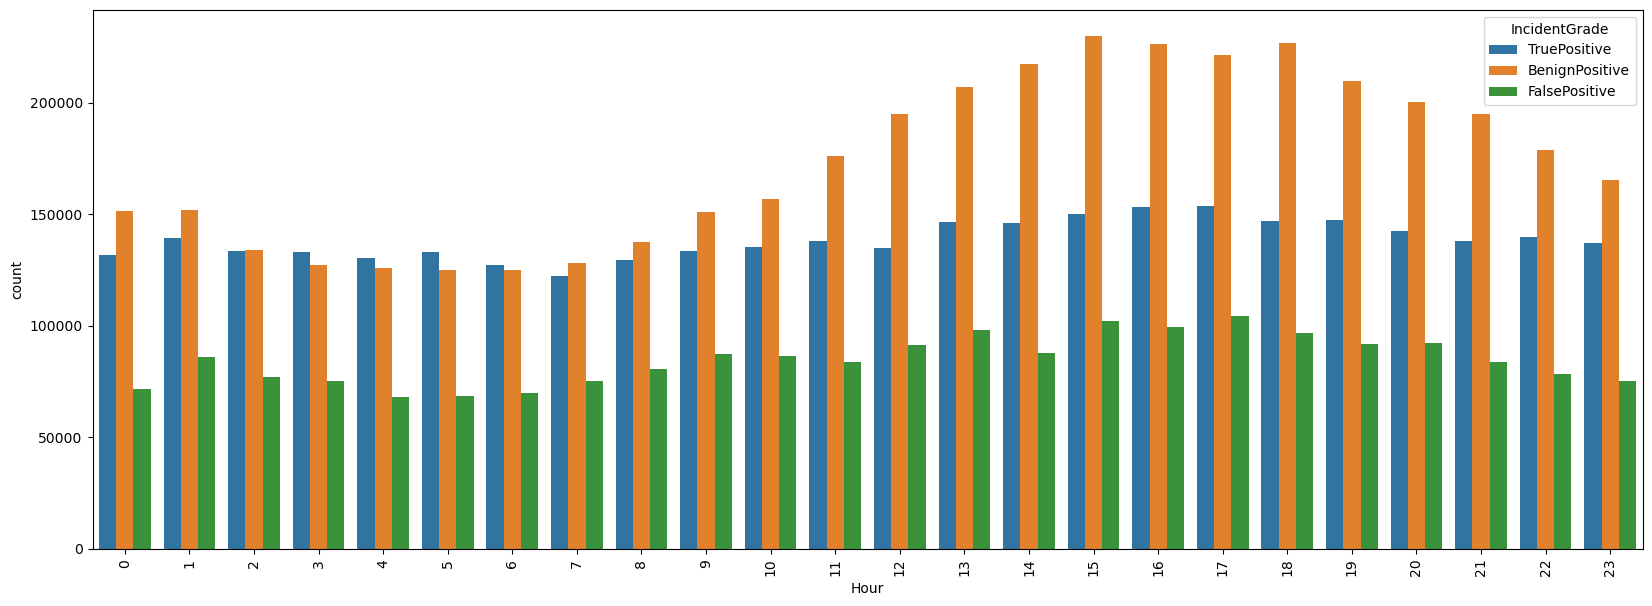

In [197]:
# Barplot for weeks vs incident grade

plt.figure(figsize=(20,7))
sns.countplot(data=data,x="Hour",hue="IncidentGrade")
plt.xticks(rotation=90)
plt.show()

In [32]:
output_path ="C:\\Users\\admin\\python\\data_cleaningtr.csv"
data.to_csv(output_path, index=False)

# ENCODING TRAIN DATASET

In [5]:
input_path ="C:\\Users\\admin\\python\\data_cleaningtr.csv"
data_cleaned=pd.read_csv(input_path) 

In [7]:
#LABEL ENCODER
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 41 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   Id                      int64 
 1   OrgId                   int64 
 2   IncidentId              int64 
 3   AlertId                 int64 
 4   DetectorId              int64 
 5   AlertTitle              int64 
 6   Category                object
 7   MitreTechniques         object
 8   IncidentGrade           object
 9   EntityType              object
 10  EvidenceRole            object
 11  DeviceId                int64 
 12  Sha256                  int64 
 13  IpAddress               int64 
 14  Url                     int64 
 15  AccountSid              int64 
 16  AccountUpn              int64 
 17  AccountObjectId         int64 
 18  AccountName             int64 
 19  DeviceName              int64 
 20  NetworkMessageId        int64 
 21  RegistryKey             int64 
 22  RegistryValueName 

In [157]:
data_cleaned.select_dtypes(include=["object"]).columns

Index(['Category', 'MitreTechniques', 'IncidentGrade', 'EntityType',
       'EvidenceRole', 'Time', 'PrimaryMitreTechniques'],
      dtype='object')

In [9]:
categorical_columns=["Category","MitreTechniques","IncidentGrade","EntityType","EvidenceRole","Time","PrimaryMitreTechniques"]

In [11]:
encoders = {}

In [13]:
# Apply LabelEncoder to each categorical column
for i in categorical_columns:
    le=LabelEncoder()
    data_cleaned[i]= le.fit_transform(data_cleaned[i])
    encoders[i]=le

In [15]:
# Save the encoders dictionary
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoders, f)

In [17]:
# STANDARDSCALER

data_cleaned.select_dtypes(include=["int32","int64"]).columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'MitreTechniques', 'IncidentGrade', 'EntityType',
       'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid',
       'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName',
       'NetworkMessageId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName',
       'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City', 'Day', 'Month',
       'Year', 'Hour', 'Time', 'PrimaryMitreTechniques'],
      dtype='object')

In [19]:
numeric_columns = ['DetectorId', 'Sha256', 'IpAddress', 'Url',
    'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 
    'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData',
    'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
    'FolderPath', 'ResourceIdName', 'State', 'City','Id', 'OrgId', 'IncidentId', 'AlertId','AlertTitle','OSVersion','OSFamily','Day', 'Month', 'Year', 'Hour', 'Time','CountryCode','EvidenceRole','AccountSid','FileName','DeviceId']


In [21]:
# Initialize and fit the scaler for numerical columns
scaler = StandardScaler()

In [23]:
data_cleaned[numeric_columns] =scaler.fit_transform(data_cleaned[numeric_columns])

In [25]:
# Save the scaler
with open("scaler.pkl","wb") as s:
    pickle.dump(scaler,s)

In [15]:
data_cleaned.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,...,OSVersion,CountryCode,State,City,Day,Month,Year,Hour,Time,PrimaryMitreTechniques
0,-1.334329,-0.469468,-0.579720,-0.616770,-0.238271,-0.256626,10,705,2,15,...,0.14433,-3.068193,-3.833510,-3.810471,-0.941726,0.310598,0.004337,-0.907286,-0.967568,104
1,-0.780419,-0.241947,-0.582086,-0.427806,-0.121057,-0.253397,7,705,1,32,...,0.14433,0.291824,0.266429,0.266155,0.682940,0.310598,0.004337,-1.349666,-1.419056,104
2,0.431260,1.622169,-0.101885,0.666231,0.717823,-0.231149,10,864,1,31,...,0.14433,0.291824,0.266429,0.266155,0.520473,0.310598,0.004337,-1.202206,-1.145216,157
3,0.881312,-0.231605,-0.311755,0.800775,-0.249762,-0.256975,1,1108,0,31,...,0.14433,0.291824,0.266429,0.266155,0.033073,0.310598,0.004337,0.567314,0.590374,287
4,-1.265091,-0.086820,-0.548711,-0.475694,-0.233674,-0.250693,6,705,2,32,...,0.14433,0.291824,0.266429,0.266155,0.845406,0.310598,0.004337,-1.644586,-1.697317,104


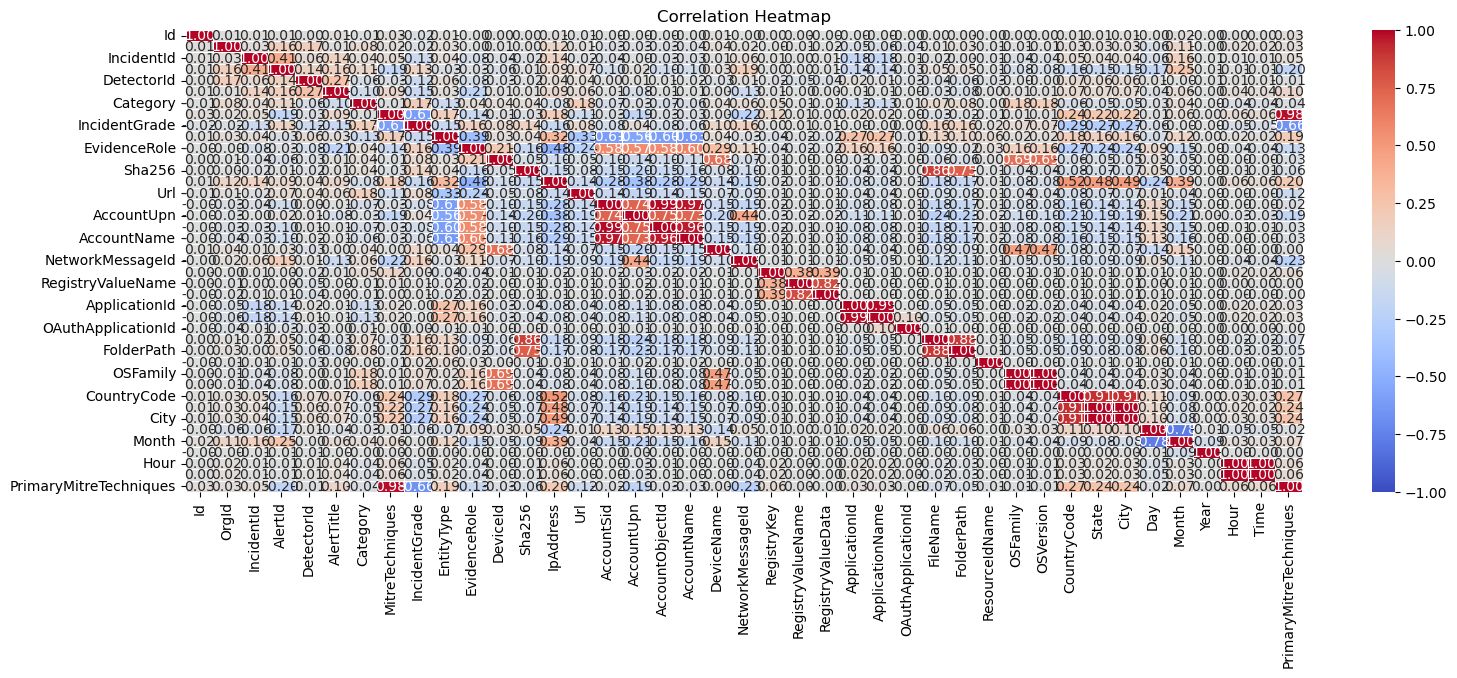

In [41]:
plt.figure(figsize=(18,6))
sns.heatmap(data=data.corr(),annot=True,fmt=".2f",cmap="coolwarm",vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# TRAIN TEST SPLIT

In [27]:
data_cleaned.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,...,OSVersion,CountryCode,State,City,Day,Month,Year,Hour,Time,PrimaryMitreTechniques
0,-1.334329,-0.469468,-0.579720,-0.616770,-0.238271,-0.256626,10,705,2,15,...,0.14433,-3.068193,-3.833510,-3.810471,-0.941726,0.310598,0.004337,-0.907286,-0.967568,104
1,-0.780419,-0.241947,-0.582086,-0.427806,-0.121057,-0.253397,7,705,1,32,...,0.14433,0.291824,0.266429,0.266155,0.682940,0.310598,0.004337,-1.349666,-1.419056,104
2,0.431260,1.622169,-0.101885,0.666231,0.717823,-0.231149,10,864,1,31,...,0.14433,0.291824,0.266429,0.266155,0.520473,0.310598,0.004337,-1.202206,-1.145216,157
3,0.881312,-0.231605,-0.311755,0.800775,-0.249762,-0.256975,1,1108,0,31,...,0.14433,0.291824,0.266429,0.266155,0.033073,0.310598,0.004337,0.567314,0.590374,287
4,-1.265091,-0.086820,-0.548711,-0.475694,-0.233674,-0.250693,6,705,2,32,...,0.14433,0.291824,0.266429,0.266155,0.845406,0.310598,0.004337,-1.644586,-1.697317,104


In [31]:
X= data_cleaned.drop("IncidentGrade",axis=1)

In [33]:
y= data_cleaned["IncidentGrade"]

In [35]:
data_cleaned["IncidentGrade"].value_counts()

IncidentGrade
0    4162157
2    3322713
1    2031967
Name: count, dtype: int64

In [61]:
# SMOTE

# smote = SMOTE(random_state=100)
# desired_chunk_size = 500000  
# n_chunks = max(1, len(X) // desired_chunk_size)

# # Initialize lists to collect results
# X_new_list = []
# y_new_list = []

# # Process in chunks
# for i in tqdm(range(n_chunks)):
#     start_index = i * desired_chunk_size
#     end_index = (i + 1) * desired_chunk_size if i != n_chunks - 1 else len(X)

#     # Extract current chunk
#     X_chunk = X.iloc[start_index:end_index]
#     y_chunk = y.iloc[start_index:end_index]

#     # Apply SMOTE
#     X_new_chunk, y_new_chunk = smote.fit_resample(X_chunk, y_chunk)

#     # Collect results
#     X_new_list.append(X_new_chunk)
#     y_new_list.append(y_new_chunk)

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [42:34<00:00, 134.46s/it]


In [63]:
# smote = SMOTE(random_state=100)  # Adjust sampling_strategy if needed
# desired_chunk_size = 500000  
# n_chunks = max(1, len(X) // desired_chunk_size)

# # Initialize lists to collect results
# X_new_list = []
# y_new_list = []

# # Process in chunks
# for i in tqdm(range(n_chunks)):
#     start_index = i * desired_chunk_size
#     end_index = (i + 1) * desired_chunk_size if i != n_chunks - 1 else len(X)

#     # Extract current chunk
#     X_chunk = X.iloc[start_index:end_index]
#     y_chunk = y.iloc[start_index:end_index]

#     # Apply SMOTE
#     X_new_chunk, y_new_chunk = smote.fit_resample(X_chunk, y_chunk)

#     # Collect results
#     X_new_list.append(X_new_chunk)
#     y_new_list.append(y_new_chunk)

# # Combine results
# X_new = pd.concat(X_new_list, ignore_index=True)
# y_new = pd.concat(y_new_list, ignore_index=True)

# # Check class distribution after SMOTE
# print("Class distribution after SMOTE:")
# print(y_new.value_counts())

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [42:16<00:00, 133.48s/it]


Class distribution after SMOTE:
IncidentGrade
2    4162157
1    4162157
0    4162157
Name: count, dtype: int64


In [39]:
X.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,EntityType,EvidenceRole,...,OSVersion,CountryCode,State,City,Day,Month,Year,Hour,Time,PrimaryMitreTechniques
0,-1.334329,-0.469468,-0.579720,-0.616770,-0.238271,-0.256626,10,705,15,0.909463,...,0.14433,-3.068193,-3.833510,-3.810471,-0.941726,0.310598,0.004337,-0.907286,-0.967568,104
1,-0.780419,-0.241947,-0.582086,-0.427806,-0.121057,-0.253397,7,705,32,-1.099549,...,0.14433,0.291824,0.266429,0.266155,0.682940,0.310598,0.004337,-1.349666,-1.419056,104
2,0.431260,1.622169,-0.101885,0.666231,0.717823,-0.231149,10,864,31,0.909463,...,0.14433,0.291824,0.266429,0.266155,0.520473,0.310598,0.004337,-1.202206,-1.145216,157
3,0.881312,-0.231605,-0.311755,0.800775,-0.249762,-0.256975,1,1108,31,0.909463,...,0.14433,0.291824,0.266429,0.266155,0.033073,0.310598,0.004337,0.567314,0.590374,287
4,-1.265091,-0.086820,-0.548711,-0.475694,-0.233674,-0.250693,6,705,32,-1.099549,...,0.14433,0.291824,0.266429,0.266155,0.845406,0.310598,0.004337,-1.644586,-1.697317,104


In [41]:
#Feature selection random forest
rf = RandomForestClassifier(n_estimators=200, random_state=100, n_jobs=-1,criterion="entropy",max_depth=10)

In [43]:
rf.fit(X,y)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=100)

In [45]:
fs_score=pd.DataFrame({
    "columns":X.columns,
    "score": rf.feature_importances_
}).sort_values("score",ascending=False)

In [47]:
fs_score

,columns,score
39,PrimaryMitreTechniques,0.234682
7,MitreTechniques,0.209784
1,OrgId,0.133862
4,DetectorId,0.092342
2,IncidentId,0.071398
5,AlertTitle,0.064228
6,Category,0.049303
3,AlertId,0.045476
34,Day,0.012416
8,EntityType,0.011456


In [49]:
list(fs_score.head(20)["columns"].values)

['PrimaryMitreTechniques',
 'MitreTechniques',
 'OrgId',
 'DetectorId',
 'IncidentId',
 'AlertTitle',
 'Category',
 'AlertId',
 'Day',
 'EntityType',
 'CountryCode',
 'AccountUpn',
 'IpAddress',
 'City',
 'DeviceName',
 'NetworkMessageId',
 'State',
 'EvidenceRole',
 'AccountSid',
 'AccountObjectId']

In [51]:
selected_features =list(fs_score.sort_values("score",ascending=False).head(20)["columns"].values)

In [53]:
X_new=X[selected_features]

In [55]:
X_new.head()

,PrimaryMitreTechniques,MitreTechniques,OrgId,DetectorId,IncidentId,AlertTitle,Category,AlertId,Day,EntityType,CountryCode,AccountUpn,IpAddress,City,DeviceName,NetworkMessageId,State,EvidenceRole,AccountSid,AccountObjectId
0,104,705,-0.469468,-0.238271,-0.579720,-0.256626,10,-0.616770,-0.941726,15,-3.068193,0.722043,-2.023194,-3.810471,0.273219,0.349872,-3.833510,0.909463,0.534128,0.530836
1,104,705,-0.241947,-0.121057,-0.582086,-0.253397,7,-0.427806,0.682940,32,0.291824,-1.520687,0.530047,0.266155,0.273219,0.349872,0.266429,-1.099549,-1.982267,-1.989320
2,157,864,1.622169,0.717823,-0.101885,-0.231149,10,0.666231,0.520473,31,0.291824,0.722043,0.530047,0.266155,0.273219,0.349872,0.266429,0.909463,0.534128,0.530836
3,287,1108,-0.231605,-0.249762,-0.311755,-0.256975,1,0.800775,0.033073,31,0.291824,0.722043,0.530047,0.266155,0.273219,0.349872,0.266429,0.909463,0.534128,0.530836
4,104,705,-0.086820,-0.233674,-0.548711,-0.250693,6,-0.475694,0.845406,32,0.291824,-1.598006,0.530047,0.266155,0.273219,0.349872,0.266429,-1.099549,-2.114144,-2.129093


In [57]:
data_x = X_new.corr()

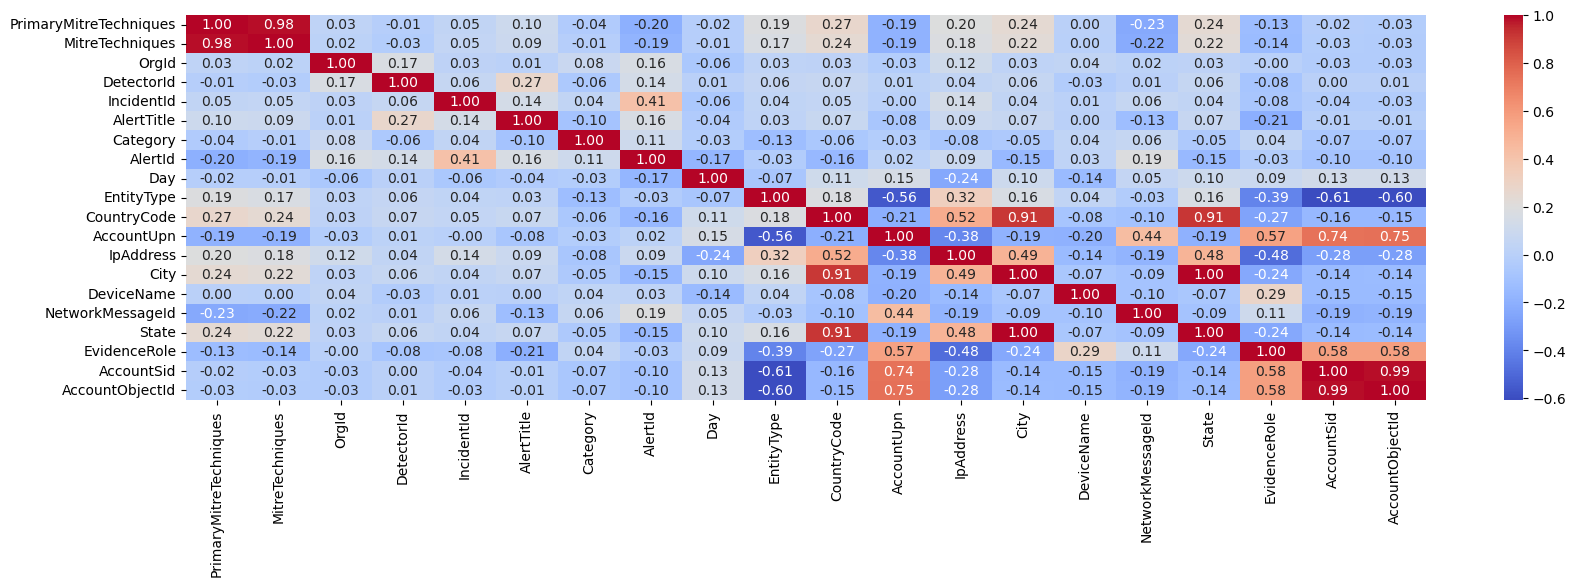

In [59]:
plt.figure(figsize=(20,5))
sns.heatmap(data=data_x,annot=True,fmt=".2f",cmap="coolwarm")
plt.show()

In [63]:
X_new.drop(["MitreTechniques","City","AccountSid","AccountObjectId","State"],axis=1,inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_1956\960774662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new.drop(["MitreTechniques","City","AccountSid","AccountObjectId","State"],axis=1,inplace=True)


In [65]:
X_new.head()

,PrimaryMitreTechniques,OrgId,DetectorId,IncidentId,AlertTitle,Category,AlertId,Day,EntityType,CountryCode,AccountUpn,IpAddress,DeviceName,NetworkMessageId,EvidenceRole
0,104,-0.469468,-0.238271,-0.579720,-0.256626,10,-0.616770,-0.941726,15,-3.068193,0.722043,-2.023194,0.273219,0.349872,0.909463
1,104,-0.241947,-0.121057,-0.582086,-0.253397,7,-0.427806,0.682940,32,0.291824,-1.520687,0.530047,0.273219,0.349872,-1.099549
2,157,1.622169,0.717823,-0.101885,-0.231149,10,0.666231,0.520473,31,0.291824,0.722043,0.530047,0.273219,0.349872,0.909463
3,287,-0.231605,-0.249762,-0.311755,-0.256975,1,0.800775,0.033073,31,0.291824,0.722043,0.530047,0.273219,0.349872,0.909463
4,104,-0.086820,-0.233674,-0.548711,-0.250693,6,-0.475694,0.845406,32,0.291824,-1.598006,0.530047,0.273219,0.349872,-1.099549


In [69]:
X_new.head()

,PrimaryMitreTechniques,OrgId,DetectorId,IncidentId,AlertTitle,Category,AlertId,Day,EntityType,CountryCode,AccountUpn,IpAddress,DeviceName,NetworkMessageId,EvidenceRole
0,104,-0.469468,-0.238271,-0.579720,-0.256626,10,-0.616770,-0.941726,15,-3.068193,0.722043,-2.023194,0.273219,0.349872,0.909463
1,104,-0.241947,-0.121057,-0.582086,-0.253397,7,-0.427806,0.682940,32,0.291824,-1.520687,0.530047,0.273219,0.349872,-1.099549
2,157,1.622169,0.717823,-0.101885,-0.231149,10,0.666231,0.520473,31,0.291824,0.722043,0.530047,0.273219,0.349872,0.909463
3,287,-0.231605,-0.249762,-0.311755,-0.256975,1,0.800775,0.033073,31,0.291824,0.722043,0.530047,0.273219,0.349872,0.909463
4,104,-0.086820,-0.233674,-0.548711,-0.250693,6,-0.475694,0.845406,32,0.291824,-1.598006,0.530047,0.273219,0.349872,-1.099549


In [71]:
X_new.shape

(9516837, 15)

In [77]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y,test_size=0.2,random_state=100)

# MODEL BUILDING

In [79]:
#decision tree
X_train.shape

(7613469, 15)

In [83]:
X_test.shape

(1903368, 15)

In [91]:
# Initialize the models

dt_model= DecisionTreeClassifier(max_depth=8,random_state=100,min_samples_split=10,min_samples_leaf=5,max_features="sqrt")

In [93]:
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, random_state=100)

In [94]:
def metrics(actual, predicted):
    acc = accuracy_score(actual, predicted) * 100
    prec = precision_score(actual, predicted, average="macro") * 100
    recall = recall_score(actual, predicted, average="macro") * 100
    macro_f1 = f1_score(actual, predicted, average="macro") * 100 
    
    return pd.DataFrame({
        "Metrics": ["Accuracy", "Precision", "Recall", "Macro F1"],
        "Values": [acc, prec, recall, macro_f1]
    }).set_index("Metrics")

In [95]:
dttr_pred =dt_model.predict(X_train)
dtts_pred =dt_model.predict(X_test)

In [96]:
dttrain_metrics=metrics(y_train,dttr_pred)

In [97]:
dttest_metrics=metrics(y_test,dtts_pred)

In [98]:
pd.DataFrame({
    "Training":dttrain_metrics["Values"],
    "Testing":dttest_metrics["Values"]
}).reset_index()


,Metrics,Training,Testing
0,Accuracy,82.849198,82.819507
1,Precision,82.332226,82.300359
2,Recall,80.195670,80.170994
3,Macro F1,80.953697,80.924246


In [102]:
print(classification_report(y_test,dtts_pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87    832150
           1       0.77      0.69      0.73    406348
           2       0.88      0.77      0.82    664870

    accuracy                           0.83   1903368
   macro avg       0.82      0.80      0.81   1903368
weighted avg       0.83      0.83      0.83   1903368



In [104]:
# RANDOM FOREST
rfc =RandomForestClassifier(criterion='entropy',max_depth=10,n_estimators=200,n_jobs=-1,random_state=100)

In [106]:
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=100)

In [108]:
rftr_pred =rfc.predict(X_train)
rfts_pred =rfc.predict(X_test)

In [109]:
rftrain_metrics=metrics(y_train,rftr_pred)
rftest_metrics=metrics(y_test,rfts_pred)

In [110]:
pd.DataFrame({
    "Training":rftrain_metrics["Values"],
    "Testing":rftest_metrics["Values"]
}).reset_index()


,Metrics,Training,Testing
0,Accuracy,88.341044,88.358688
1,Precision,88.952631,88.966957
2,Recall,86.091605,86.114338
3,Macro F1,87.152912,87.172555


In [113]:
print(classification_report(y_test,rfts_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91    832150
           1       0.88      0.77      0.82    406348
           2       0.94      0.83      0.88    664870

    accuracy                           0.88   1903368
   macro avg       0.89      0.86      0.87   1903368
weighted avg       0.89      0.88      0.88   1903368



In [115]:
# XGBoost
xgbmodel = xgboost.XGBClassifier(n_estimators=200,learning_rate=0.1,random_state=100,n_jobs=-1,max_depth=8)

In [117]:
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [119]:
xgbtr_pred =xgbmodel.predict(X_train)
xgbts_pred =xgbmodel.predict(X_test)

In [120]:
xgbtrain_metrics = metrics(y_train,xgbtr_pred)
xgbtest_metrics =metrics(y_test,xgbts_pred)

In [121]:
pd.DataFrame({
    "Training":xgbtrain_metrics["Values"],
    "Testing":xgbtest_metrics["Values"]
}).reset_index()


,Metrics,Training,Testing
0,Accuracy,95.751936,95.713336
1,Precision,95.633582,95.587524
2,Recall,95.119809,95.081322
3,Macro F1,95.365759,95.323704


In [122]:
print(classification_report(y_test,xgbts_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    832150
           1       0.95      0.92      0.94    406348
           2       0.96      0.95      0.95    664870

    accuracy                           0.96   1903368
   macro avg       0.96      0.95      0.95   1903368
weighted avg       0.96      0.96      0.96   1903368



In [127]:
score = cross_val_score(xgbmodel, X_train, y_train, cv=3, scoring="accuracy")
print("Cross-validation accuracy: ", score.mean())

Cross-validation accuracy:  0.9574380614145799


In [129]:
#saving best model
best_model = "XGB.joblib"

In [131]:
with open(best_model, 'wb') as file:
    joblib.dump(xgbmodel, file)

# TEST DATASET

In [194]:
#file paths
input_path ="GUIDE_Test.csv"
data_test=pd.read_csv(input_path)

C:\Users\admin\AppData\Local\Temp\ipykernel_1956\3433393273.py:3: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_test=pd.read_csv(input_path)


In [167]:
data_test.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,2610,3699,425863,863,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,NaN,NaN,Machine,Impacted,1239,138268,360606,160396,441377,673934,425863,453297,2833,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,NaN,NaN,Process,Related,98799,4296,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,14,22,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,NaN,NaN,CloudLogonSession,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,133549,673934,425863,136104,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [166]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 46 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [168]:
data_test.isnull().mean()*100

Id                     0.000000
OrgId                  0.000000
IncidentId             0.000000
AlertId                0.000000
Timestamp              0.000000
DetectorId             0.000000
AlertTitle             0.000000
Category               0.000000
MitreTechniques       55.619779
IncidentGrade          0.000000
ActionGrouped         99.953881
ActionGranular        99.953881
EntityType             0.000000
EvidenceRole           0.000000
DeviceId               0.000000
Sha256                 0.000000
IpAddress              0.000000
Url                    0.000000
AccountSid             0.000000
AccountUpn             0.000000
AccountObjectId        0.000000
AccountName            0.000000
DeviceName             0.000000
NetworkMessageId       0.000000
EmailClusterId        98.994526
RegistryKey            0.000000
RegistryValueName      0.000000
RegistryValueData      0.000000
ApplicationId          0.000000
ApplicationName        0.000000
OAuthApplicationId     0.000000
ThreatFa

In [196]:
#removing 50% and above missing data

threshold = len(data_test)*0.4
data_test = data_test.dropna(thresh=threshold,axis=1)

In [246]:
data_test.isnull().mean()*100

Id                     0.000000
OrgId                  0.000000
IncidentId             0.000000
AlertId                0.000000
Timestamp              0.000000
DetectorId             0.000000
AlertTitle             0.000000
Category               0.000000
MitreTechniques       55.619779
IncidentGrade          0.000000
EntityType             0.000000
EvidenceRole           0.000000
DeviceId               0.000000
Sha256                 0.000000
IpAddress              0.000000
Url                    0.000000
AccountSid             0.000000
AccountUpn             0.000000
AccountObjectId        0.000000
AccountName            0.000000
DeviceName             0.000000
NetworkMessageId       0.000000
RegistryKey            0.000000
RegistryValueName      0.000000
RegistryValueData      0.000000
ApplicationId          0.000000
ApplicationName        0.000000
OAuthApplicationId     0.000000
FileName               0.000000
FolderPath             0.000000
ResourceIdName         0.000000
OSFamily

In [198]:
data_test.drop_duplicates()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,User,Impacted,98799,138268,360606,160396,2610,3699,425863,863,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,Machine,Impacted,1239,138268,360606,160396,441377,673934,425863,453297,2833,529644,1631,635,860,2251,3421,881,289573,117668,3586,0,0,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,Process,Related,98799,4296,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,14,22,3586,5,66,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,CloudLogonSession,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,User,Impacted,98799,138268,360606,160396,133549,673934,425863,136104,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,171798692464,42,391,638112,2024-06-03T20:24:41.000Z,135,7322,Malware,NaN,BenignPositive,Machine,Impacted,4,138268,360606,160396,441377,673934,425863,453297,4,529644,1631,635,860,2251,3421,881,289573,117668,3586,0,0,242,1445,10630,Public
4147987,541165881145,262,3017,227156,2024-06-04T03:53:15.000Z,139,120,InitialAccess,T1566.002,BenignPositive,User,Impacted,98799,138268,360606,160396,13354,13012,13489,14567,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public
4147988,438086666953,1323,31001,304819,2024-06-04T19:32:19.000Z,219,196,InitialAccess,NaN,BenignPositive,User,Impacted,98799,138268,360606,160396,95744,172717,96809,107151,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Private
4147989,1297080124487,47,3653,7243,2024-06-15T00:50:22.000Z,57,29,CommandAndControl,T1046;T1071;T1210,FalsePositive,Ip,Related,98799,138268,1084,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Public


In [200]:
#mode imputation because of catagorial columns

data_test["IncidentGrade"].fillna(data_test["IncidentGrade"].mode()[0],inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_1956\1408043372.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_test["IncidentGrade"].fillna(data_test["IncidentGrade"].mode()[0],inplace=True)


In [175]:
data_test["Timestamp"]

0          2024-06-04T22:56:27.000Z
1          2024-06-03T12:58:26.000Z
2          2024-06-08T03:20:49.000Z
3          2024-06-12T12:07:31.000Z
4          2024-06-06T17:42:05.000Z
                     ...           
4147987    2024-06-04T03:53:15.000Z
4147988    2024-06-04T19:32:19.000Z
4147989    2024-06-15T00:50:22.000Z
4147990    2024-06-11T16:18:12.000Z
4147991    2024-06-04T18:11:09.000Z
Name: Timestamp, Length: 4147992, dtype: object

In [202]:
data_test["Timestamp"] = data_test["Timestamp"].str.replace(r"\.\d{3}Z$","Z",regex=True)

In [203]:
data_test["Timestamp"] = pd.to_datetime(data_test["Timestamp"])

In [204]:
data_test["Day"] = data_test["Timestamp"].dt.day
data_test["Month"] = data_test["Timestamp"].dt.month
data_test["Year"] = data_test["Timestamp"].dt.year
data_test["Hour"] =data_test["Timestamp"].dt.hour
data_test["Time"] =data_test["Timestamp"].dt.time
data_test.drop("Timestamp",axis=1,inplace=True)

In [205]:
pd.set_option("display.max_columns", None)
data_test.head(1)

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage,Day,Month,Year,Hour,Time
0,1245540519230,657,11767,87199,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,User,Impacted,98799,138268,360606,160396,2610,3699,425863,863,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,Private,4,6,2024,22,22:56:27


In [185]:
data_test["MitreTechniques"].value_counts()

MitreTechniques
T1078;T1078.004                                          615921
T1566.002                                                359720
T1566                                                    275358
T1133                                                    107607
T1566.001                                                 60023
                                                          ...  
T0814;T0816                                                   1
T1087;T1580;T1619;T1482;T1615;T1201;T1069;T1082;T1033         1
T0814                                                         1
T1125                                                         1
T1007;T1033;T1053                                             1
Name: count, Length: 985, dtype: int64

In [210]:
# Analyze the relationship between missing MitreTechniques and IncidentGrade
missing_datas = data_test.groupby(data_test["MitreTechniques"].isnull())['IncidentGrade'].value_counts()
# Group by IncidentGrade and MitreTechniques and count occurrences
technique_count=data_test.groupby(["IncidentGrade", "MitreTechniques"]).size().reset_index(name="count")
# Sort the counts to find the most frequent techniques for each grade
sorted_technique= technique_count.sort_values(["IncidentGrade","count"],ascending=[True, False])
# Get the most common MitreTechnique for each IncidentGrade
most_commons=sorted_technique.loc[sorted_technique.groupby("IncidentGrade")["count"].idxmax()]

In [211]:
#fill mapping based on your results
fill_mapping = {
    "BenignPositive":"T1566.002",
    "FalsePositive":"T1078;T1078.004",
    "TruePositive":"T1078;T1078.004"
}
# Fill missing MitreTechniques based on IncidentGrade
for grade,technique in fill_mapping.items():
    data_test.loc[data_test["IncidentGrade"] == grade,"MitreTechniques"] = data_test["MitreTechniques"].fillna(technique)

In [212]:
data_test["PrimaryMitreTechniques"] = data_test["MitreTechniques"].map(lambda x: x.split(";")[0])

In [141]:
data_test.isnull().sum()

Id                        0
OrgId                     0
IncidentId                0
AlertId                   0
DetectorId                0
AlertTitle                0
Category                  0
MitreTechniques           0
IncidentGrade             0
EntityType                0
EvidenceRole              0
DeviceId                  0
Sha256                    0
IpAddress                 0
Url                       0
AccountSid                0
AccountUpn                0
AccountObjectId           0
AccountName               0
DeviceName                0
NetworkMessageId          0
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
FileName                  0
FolderPath                0
ResourceIdName            0
OSFamily                  0
OSVersion                 0
CountryCode               0
State                     0
City                      0
Usage               

# ENCODING

In [191]:
data_test.select_dtypes(include=["object"]).columns

Index(['Category', 'MitreTechniques', 'IncidentGrade', 'EntityType',
       'EvidenceRole', 'Usage', 'Time', 'PrimaryMitreTechniques'],
      dtype='object')

In [216]:
# Load the encoders
    
categorical_columns=["Category","MitreTechniques","IncidentGrade","EntityType","EvidenceRole","Time","PrimaryMitreTechniques"]

encoders = {}

for i in categorical_columns:
    le=LabelEncoder()                                          # I can't load my train encoder here because both categorires has different unique values
    data_test[i]= le.fit_transform(data_test[i])         #  getting this error ValueError: y contains previously unseen labels: 11
    encoders[i]=le
    data_test[i] = data_test[i].astype(int)
# Save the encoders dictionary
with open("encoder_test.pkl", "wb") as f:
    pickle.dump(encoders, f)                          

In [428]:
for column in categorical_columns:
    if column in data_cleaned.columns and column in data_test.columns:
        print(f"Training unique values for {column}: {data_cleaned[column].unique()}")
        print(f"Test unique values for {column}: {data_test[column].unique()}")

Training unique values for Category: [10  7  1  6 16  9  0  2 13  5 12  4  8 14 11 15 17  3 19 18]
Test unique values for Category: [11  1 10  5 16  9  2  7 17  4 12  6 13  3  0 15  8 14 18]
Training unique values for MitreTechniques: [ 705  864 1108 ...  559 1111  700]
Test unique values for MitreTechniques: [311 920 303 577 610 666 917 170 937 392 474 556 692  78 895 918 661 656
 560 393 578 567 489 660 365 325 521 659 339 607 564 652 497 111 473 128
 166  68 516 641 814 406 525 233 342 697 719 331 819 929 721 757 787 390
 461 967 162 806 600 447 801 531 747 290 901 795 436 944 838  57 824 550
 740 598 800 391 782 167 866  39  44 151   9 934 332 899 738 938 713 919
 465 268 424  28  74 723 580 469 792 276 811 635 538 959 387 714 968  34
 612  43 457 625 864 942 830 940 243 887 448 739 289 581 822 519 572 818
 836 263 839 842 373 683 943 472 400 790 468 383 628 912 346 885 175  89
 884  33 835 914  98 202 385 791 873 204 356 596 113 693 773 335 563 551
 624 486  36 250 511 161 349 242

In [218]:
# STANDARD SCALER

with open("scaler.pkl", "rb") as f:
    scaler_encoders = pickle.load(f)



In [220]:
numeric_columns = ['DetectorId', 'Sha256', 'IpAddress', 'Url',
    'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 
    'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData',
    'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
    'FolderPath', 'ResourceIdName', 'State', 'City','Id', 'OrgId', 'IncidentId', 'AlertId','AlertTitle','OSVersion','OSFamily', 'Day', 'Month', 'Year', 'Hour', 'Time','CountryCode','EvidenceRole','AccountSid','FileName','DeviceId']

# scaler to the numeric columns
data_test[numeric_columns] = scaler_encoders.transform(data_test[numeric_columns])

In [222]:
data_test.drop(columns=["Usage"], inplace=True)

In [437]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 41 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Id                      float64
 1   OrgId                   float64
 2   IncidentId              float64
 3   AlertId                 float64
 4   DetectorId              float64
 5   AlertTitle              float64
 6   Category                int32  
 7   MitreTechniques         int32  
 8   IncidentGrade           int32  
 9   EntityType              int32  
 10  EvidenceRole            float64
 11  DeviceId                float64
 12  Sha256                  float64
 13  IpAddress               float64
 14  Url                     float64
 15  AccountSid              float64
 16  AccountUpn              float64
 17  AccountObjectId         float64
 18  AccountName             float64
 19  DeviceName              float64
 20  NetworkMessageId        float64
 21  RegistryKey             float64

# TRAIN TEST SPLIT

In [224]:
X1=data_test[['PrimaryMitreTechniques','OrgId','DetectorId','IncidentId','AlertTitle','Category','AlertId','Day','EntityType','CountryCode','AccountUpn',
             'IpAddress','DeviceName','NetworkMessageId','EvidenceRole']]

In [226]:
y1= data_test["IncidentGrade"]

In [228]:
X_train,X_test,y_train,y_test=train_test_split(X1,y1,test_size=0.2,random_state=100)

In [230]:
X_train.shape

(3318393, 15)

In [232]:
X_test.shape

(829599, 15)

In [234]:
best_model = joblib.load("C:\\Users\\admin\\python\\Microsoft-Classifying Cybersecurity Incidents with Machine Learning\\XGB.joblib")

In [236]:
xgbtest_pred= best_model.predict(X1)

In [238]:
metrics(y1,xgbtest_pred).reset_index()

,Metrics,Values
0,Accuracy,83.516289
1,Precision,82.706340
2,Recall,82.549785
3,Macro F1,82.549795


In [240]:
print(classification_report(y1,xgbtest_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84   1752940
           1       0.74      0.77      0.75    902698
           2       0.92      0.85      0.89   1492354

    accuracy                           0.84   4147992
   macro avg       0.83      0.83      0.83   4147992
weighted avg       0.84      0.84      0.84   4147992

